### Imports

In [13]:
import pandas as pd
import datetime
import os
import sys
import math
import matplotlib.pyplot as plt
import numpy as np
import warnings
from pandas.errors import SettingWithCopyWarning


warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

### Parameters

In [14]:
buy_threshold = 1.04
sell_threshold = 1.04
starting_balance = 1000000
price_cap_lower = 0

run_optimizing = False
google_colab = False
preparing_file = True
write_file = True

### Data loading

In [15]:
if google_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install -U -q PyDrive
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    # Authenticate and create the PyDrive client.
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    id = "111QpHwxMy28NV8I23Bj_ZD1H32H6n7bV"
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile('11.05 1 mnd test sett full model run.csv')  
    df = pd.read_csv('11.05 1 mnd test sett full model run.csv')
else:
    # Set the path to the root directory
    path = os.path.abspath(os.path.join(os.getcwd(), '../..'))
    # Read dataframes using Dask
    df = pd.read_csv(path + '/data/predictions/11.05 1 mnd test sett full model run.csv')

### Data processing

In [16]:
if preparing_file:
        # Convert TTM to days as int
        df['TTM'] = df['TTM'].astype(int)
        # Dates
        df['Expiry_date'] = pd.to_datetime(df['Quote_date']) + pd.to_timedelta(df['TTM'], unit='D')
        df['Quote_date'] = pd.to_datetime(df['Quote_date']).dt.date 
        df['Expiry_date'] = pd.to_datetime(df['Expiry_date']).dt.date 
        # Adding option ID
        df["Option_ID"] = df["Expiry_date"].astype(str) + "-" + df["Strike"].astype(str)

        df_original = df[(df["Quote_date"] >= pd.to_datetime("2019-01-01").date()) & 
                        (df["Quote_date"] <= pd.to_datetime("2020-01-01").date())]

        df = df[(df["Expiry_date"] >= pd.to_datetime("2019-01-01").date()) & 
                (df["Expiry_date"] <= pd.to_datetime("2019-12-31").date())]

        df = df[(df["Quote_date"] >= pd.to_datetime("2019-01-01").date()) & 
                (df["Quote_date"] <= pd.to_datetime("2019-12-31").date())]

        # Only keep 5% of the OptionID groups at random
        df = df.groupby('Option_ID').apply(lambda x: x.sample(frac=0.05, random_state=1))        

In [17]:
print(len(df))

62465


In [18]:
display(df)
display(df.sample(10))

Unnamed: 0  Quote_date     Price  Prediction  \
Option_ID                                                                 
2019-01-02-1300.0 3855330     5373486  2019-01-02  1197.105   1194.4602   
2019-01-02-1325.0 3853064     5371220  2019-01-02  1182.745   1174.8423   
2019-01-02-1350.0 3852379     5370535  2019-01-02  1157.595   1150.4400   
2019-01-02-1375.0 3853066     5371222  2019-01-02  1131.995   1125.5415   
2019-01-02-1400.0 3855334     5373490  2019-01-02  1103.055   1097.4149   
...                               ...         ...       ...         ...   
2019-12-31-3700.0 5162362     6680518  2019-12-30    31.805     31.1926   
                  5167326     6685482  2019-12-31     1.700      0.0000   
2019-12-31-3800.0 5167776     6685932  2019-12-31     5.140      0.0000   
2019-12-31-3900.0 5166955     6685111  2019-12-31     0.175      0.0000   
2019-12-31-4000.0 5167605     6685761  2019-12-31     0.500      0.0000   

                           Underlying_last  Strike  TTM         R Expiry_date  \
Option_ID                                                                       
2019-01-02-1300.0 3855330          2509.98  1300.0    0  0.025049  2019-01-02   
2019-01-02-1325.0 3853064          2509.98  1325.0    0  0.024000  2019-01-02   
2019-01-02-1350.0 3852379          2509.98  1350.0    0  0.024000  2019-01-02   
2019-01-02-1375.0 3853066          2509.98  1375.0    0  0.024000  2019-01-02   
2019-01-02-1400.0 3855334          2509.98  1400.0    0  0.025049  2019-01-02   
...                                    ...     ...  ...       ...         ...   
2019-12-31-3700.0 5162362          3221.81  3700.0    1  0.015796  2019-12-31   
                  5167326          3229.70  3700.0    0  0.015806  2019-12-31   
2019-12-31-3800.0 5167776          3229.70  3800.0    0  0.015986  2019-12-31   
2019-12-31-3900.0 5166955          3229.70  3900.0    0  0.015665  2019-12-31   
2019-12-31-4000.0 5167605          3229.70  4000.0    0  0.015931  2019-12-31   

                                   Option_ID  
Option_ID                                     
2019-01-02-1300.0 3855330  2019-01-02-1300.0  
2019-01-02-1325.0 3853064  2019-01-02-1325.0  
2019-01-02-1350.0 3852379  2019-01-02-1350.0  
2019-01-02-1375.0 3853066  2019-01-02-1375.0  
2019-01-02-1400.0 3855334  2019-01-02-1400.0  
...                                      ...  
2019-12-31-3700.0 5162362  2019-12-31-3700.0  
                  5167326  2019-12-31-3700.0  
2019-12-31-3800.0 5167776  2019-12-31-3800.0  
2019-12-31-3900.0 5166955  2019-12-31-3900.0  
2019-12-31-4000.0 5167605  2019-12-31-4000.0  

[62465 rows x 10 columns]

,,Unnamed: 0,Quote_date,Price,Prediction,Underlying_last,Strike,TTM,R,Expiry_date,Option_ID
Option_ID,,,,,,,,,,,
2019-03-27-2540.0,4151918,5670074,2019-03-27,271.950,268.647600,2805.33,2540.0,0,0.024452,2019-03-27,2019-03-27-2540.0
2019-10-18-2350.0,4874456,6392612,2019-10-17,690.600,679.381200,2998.23,2350.0,1,0.015998,2019-10-18,2019-10-18-2350.0
2019-06-25-2400.0,4457839,5975995,2019-06-24,606.305,625.024840,2945.54,2400.0,1,0.018030,2019-06-25,2019-06-25-2400.0
2019-02-12-2350.0,4007310,5525466,2019-02-12,423.395,429.472960,2744.03,2350.0,0,0.024895,2019-02-12,2019-02-12-2350.0
2019-09-18-2775.0,4764114,6282270,2019-09-18,237.750,233.459670,3006.74,2775.0,0,0.019400,2019-09-18,2019-09-18-2775.0
2019-10-29-2780.0,4915788,6433944,2019-10-29,291.350,286.387940,3036.71,2780.0,0,0.016350,2019-10-29,2019-10-29-2780.0
2019-09-12-3150.0,4744283,6262439,2019-09-12,4.250,6.731031,3009.77,3150.0,0,0.019813,2019-09-12,2019-09-12-3150.0
2019-05-09-2430.0,4302782,5820938,2019-05-09,440.645,443.397640,2870.29,2430.0,0,0.024300,2019-05-09,2019-05-09-2430.0
2019-05-22-3010.0,4350045,5868201,2019-05-22,8.400,10.939351,2856.25,3010.0,0,0.023791,2019-05-22,2019-05-22-3010.0


In [19]:
df_after_dates = df.copy()

Adding TTM=0 row

In [24]:
if preparing_file:
    df = df_after_dates.copy()
    # Sort the dataframe by Quote_date and Expiry_date
    df = df.sort_values(['Quote_date', 'Expiry_date'])
    df["Expiry_date"] = pd.to_datetime(df["Expiry_date"])

    groups = df.groupby(['Expiry_date', 'Strike'])

    for _, group in groups:

        # Sort group so that the last row is the one with the lowest TTM
        group = group.sort_values('TTM', ascending=False)

        # Taking row from option group (could be any) to be used in getting the Strike price
        last_row = group.iloc[-1]
        # Get the expiry date and turn it into a datetime

        # Get the underlying price on the day of expiry
        expiry_date = last_row['Expiry_date']
        # Turn expiry_date into datetime.date
        expiry_date = expiry_date.date()
        # print type of expiry_date

        if expiry_date not in df_original['Quote_date'].values:
            print("Expiry date not in df_original: ", expiry_date)
            print("Weekday: ", expiry_date.weekday())

            df = df[df["Option_ID"] != last_row["Option_ID"]]
            continue

        underlying_last_on_expiry = df_original.loc[df_original['Quote_date'] == expiry_date, 'Underlying_last'].iloc[0]
        # Calculate the intrinsic value
        intrinsic_value = np.maximum(underlying_last_on_expiry - last_row['Strike'], 0)

        new_row = last_row.copy()
        new_row['Quote_date'] = expiry_date
        new_row['Expiry_date'] = expiry_date
        new_row['TTM'] = 0
        new_row['Underlying_last'] = underlying_last_on_expiry
        new_row['Price'] = intrinsic_value

        # Append the new row to the dataframe
        new_row_df = pd.DataFrame(new_row).transpose()
        df = pd.concat([df, new_row_df], ignore_index=True)

    # Sort the dataframe by Quote_date and Expiry_date
    df = df.sort_values(['Quote_date', 'Expiry_date'])

In [ ]:
df_after_expiry = df.copy()
del df_after_dates

### Make sure prices are available every day for an option group

In [ ]:
if preparing_file:
    df = df_after_expiry.copy()
    unique_dates = df['Quote_date'].unique()

    option_groups = df.groupby(['Option_ID'])

    # Remove option groups if it has a date between it's first and last that is not in unique_dates
    for option_id, option_group in option_groups:
        group_first_date = option_group['Quote_date'].iloc[0]
        group_last_date = option_group['Quote_date'].iloc[-1]

        if group_first_date not in unique_dates or group_last_date not in unique_dates:
            df = df.drop(option_group.index)
            print("Dropped option group: ", option_id, " because it's first or last date is not in unique_dates")

        # If every unique_dates between group_first_date and group_last_date is not in group, drop the group
        # Print type of unique_dates
        print("Unique dates type: ", type(unique_dates))
        # Print type of group_first_date
        print("Group first date type: ", type(group_first_date))
        # Print type of group_last_date
        print("Group last date type: ", type(group_last_date))
        # Print type of option_group['Quote_date']
        print("Option group quote date type: ", type(option_group['Quote_date']))

        dates_between = unique_dates[(unique_dates >= group_first_date) & (unique_dates <= group_last_date)]
        if len(dates_between) != len(option_group['Quote_date'].unique()):
            df = df.drop(option_group.index)
            print("Dropped option group: ", option_id, " because it's missing dates between it's first and last date")


        if len(option_group) < 2:
            df = df.drop(option_group.index)
            print("Dropped option group: ", option_id, " because it has less than 2 rows")


/var/folders/wk/x86_p6511l95p594k6qnb98h0000gn/T/ipykernel_4263/3407952255.py:11: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for option_id, option_group in option_groups:


Dropped option group:  2019-01-02-2485.0  because a date between it's first and last is not in the group
Dropped option group:  2019-01-02-2490.0  because a date between it's first and last is not in the group
Dropped option group:  2019-01-02-2495.0  because a date between it's first and last is not in the group
Dropped option group:  2019-01-02-2500.0  because a date between it's first and last is not in the group
Dropped option group:  2019-01-02-2505.0  because a date between it's first and last is not in the group
Dropped option group:  2019-01-02-2510.0  because a date between it's first and last is not in the group
Dropped option group:  2019-01-02-2515.0  because a date between it's first and last is not in the group
Dropped option group:  2019-01-02-2520.0  because a date between it's first and last is not in the group
Dropped option group:  2019-01-02-2525.0  because a date between it's first and last is not in the group
Dropped option group:  2019-01-02-2530.0  because a dat

KeyboardInterrupt: 

In [ ]:
print(len(df))
display(df)

18358


In [ ]:
# Write df to file
if write_file:
    df.to_csv(path + '/data/predictions/trading_data-2019.csv', index=False)

### Functions

In [ ]:
def generate_buy_sell_signals(df, buy_threshold, sell_threshold):
    buy_signal = (df['Prediction'] / df['Price']) >= buy_threshold
    sell_signal = (df['Price'] / df['Prediction']) >= sell_threshold
    return buy_signal, sell_signal


def trader(df, buy_signal, sell_signal, starting_balance, price_cap_lower):
    df = df.copy()
    # Filter out options that expire before the last quote date
    last_date = df['Quote_date'].max()
    df = df[df['Expiry_date'] <= last_date]
    
    df['Signal'] = 0
    df.loc[buy_signal, 'Signal'] = 1
    df.loc[sell_signal, 'Signal'] = -1
    df['Position_this_opt'] = 0
    df['Balance'] = starting_balance  # Initialize Balance column with starting_balance
    df['Profit'] = 0

    quote_date_grouped = df.groupby('Quote_date')

    balance = starting_balance

    for quote_date, group in quote_date_grouped:
        group = group.sample(frac=1)

        for _, row in group.iterrows():
            # Don't consider options with a price lower than 3
            if row['Price'] < price_cap_lower:
                continue

            option_position = df.loc[(df['Option_ID'] == row['Option_ID']) & (df['Quote_date'] <= row['Quote_date']), 'Position_this_opt'].iloc[-1]

            # Buy the option
            if row['Signal'] == 1 and balance >= row['Price'] and row["Quote_date"] != row["Expiry_date"]:
                balance -= row['Price']
                option_position += 1
                # Directly update values in the original dataframe
                df.loc[(df['Option_ID'] == row['Option_ID']) & (df['Quote_date'] == row['Quote_date']), 'Position_this_opt'] = option_position
                df.loc[(df['Option_ID'] == row['Option_ID']) & (df['Quote_date'] == row['Quote_date']), 'Balance'] = balance

            # Sell the option
            elif row['Signal'] == -1 and row["Quote_date"] != row["Expiry_date"] and balance > 0:
                balance += row['Price']
                option_position -= 1
                # Directly update values in the original dataframe
                df.loc[(df['Option_ID'] == row['Option_ID']) & (df['Quote_date'] == row['Quote_date']), 'Position_this_opt'] = option_position
                df.loc[(df['Option_ID'] == row['Option_ID']) & (df['Quote_date'] == row['Quote_date']), 'Balance'] = balance

            # Option expires
            elif row["Quote_date"] == row["Expiry_date"] and option_position != 0:
                intrinsic_value = max(0, row['Underlying_last'] - row['Strike'])
                adjustment = intrinsic_value if option_position >= 1 else -intrinsic_value
                balance += adjustment * abs(option_position)
                option_position = 0
                # Directly update values in the original dataframe
                df.loc[(df['Option_ID'] == row['Option_ID']) & (df['Quote_date'] == row['Quote_date']), 'Position_this_opt'] = option_position
                df.loc[(df['Option_ID'] == row['Option_ID']) & (df['Quote_date'] == row['Quote_date']), 'Balance'] = balance

            # For the rows that are not buy, sell or expire, update the balance
            df.loc[(df['Quote_date'] == quote_date) & (df['Position_this_opt'] == 0), 'Balance'] = balance
        
    return df


def calculate_options_value(df):
    df['Options_value'] = 0
    # Iterate over every Quote_date
    for date in df['Quote_date'].unique():
        # For every Quote date, multiply each row's Position_this_opt with the Price and sum it up.
        options_value_sum = (df.loc[df['Quote_date'] == date, 'Position_this_opt'] * df.loc[df['Quote_date'] == date, 'Price']).sum()
        # The result should be added to every row with the same Quote_date in the Options_value
        df.loc[df['Quote_date'] == date, 'Options_value'] = options_value_sum
    df['Total_value'] = df['Balance'] + df['Options_value']
    return df

### Run code

In [ ]:
from pandas import to_datetime

def print_results(df, starting_balance):
    print("Starting balance", starting_balance)
    print("Ending balance", df['Balance'].iloc[-1])
    print("Number of trades", df['Signal'].abs().sum())
    profit = df['Balance'].iloc[-1] - starting_balance
    print("Profit", profit)
    print("Profit per trade", profit / df['Signal'].abs().sum())
    # Convert the 'Quote_date' column to datetime
    df['Quote_date'] = to_datetime(df['Quote_date'])
    print("Profit per day", profit / (df['Quote_date'].max() - df['Quote_date'].min()).days)
    num_days = (df['Quote_date'].max() - df['Quote_date'].min()).days
    print("Number of days", num_days)
    print("Sharpe ratio: ", sharpe_ratio2(df))


In [ ]:
def sharpe_ratio(df):
    df = df.copy()
    # Group by Quote_date and keep the last row of each group
    df = df.groupby('Quote_date').last()
    # Calculate daily returns
    df['Daily_Returns'] = df['Total_value'].pct_change()
    # Convert the annual risk-free rate to a daily rate
    df['Daily_Rf'] = (1 + df['R'])**(1/252) - 1
    # Calculate the excess returns
    excess_returns = df['Daily_Returns'] - df['Daily_Rf']
    # Calculate sharpe ratio
    sharpe_ratio = np.sqrt(252) * (excess_returns.mean() / excess_returns.std())
    return sharpe_ratio

In [ ]:
def sharpe_ratio2(df, rf=0.02):
    df = df.copy()

    # Calculate daily returns
    df['Daily_Returns'] = df['Total_value'].pct_change()

    starting_balance = df['Balance'].iloc[0]
    ending_balance = df['Balance'].iloc[-1]

    num_days = (df['Quote_date'].max() - df['Quote_date'].min()).days

    avg_daily_return = (ending_balance / starting_balance)**(1/num_days) - 1

    avg_daily_return_excess = avg_daily_return - rf / 252

    df["Excess_Returns"] = df["Daily_Returns"] - rf / 252

    std_daily_excess_return = df["Excess_Returns"].std()

    sharpe_ratio = np.sqrt(252) * (avg_daily_return_excess / std_daily_excess_return)

    return sharpe_ratio

In [ ]:
if run_optimizing == False:
    df = df.copy()
    buy_signal, sell_signal = generate_buy_sell_signals(df, buy_threshold, sell_threshold)
    df = trader(df, buy_signal, sell_signal, starting_balance, price_cap_lower)
    df = calculate_options_value(df)
    print_results(df, starting_balance)

Starting balance 1000000
Ending balance 1389062.8549999886
Number of trades 9499
Profit 389062.8549999886
Profit per trade 40.958296136434214
Profit per day 2210.584403409026
Number of days 176
Sharpe ratio:  0.3185965415041829


In [ ]:
display(df)

Unnamed: 0 Quote_date     Price  Prediction  \
Option_ID                                                               
2018-01-17-1600.0 7518       4127699 2018-01-04  1123.500  1129.90480   
2018-01-17-1700.0 7519       4127700 2018-01-04  1023.800  1029.49570   
2018-01-17-1750.0 7520       4127701 2018-01-04   973.595   979.17377   
2018-01-17-1800.0 7521       4127702 2018-01-04   923.595   929.32916   
2018-01-17-1850.0 7522       4127703 2018-01-04   873.705   879.45780   
...                              ...        ...       ...         ...   
2018-06-29-3200.0 215006     4369941 2018-03-22     0.420     0.00000   
                  261644     4430407 2018-04-10     0.325     0.00000   
                  347302     4555317 2018-05-16     0.050     0.00000   
                  307478     4492998 2018-04-27     0.080     0.00000   
                  391376     4661901 2018-06-19     0.025     0.00000   

                          Underlying_last  Strike       TTM         R  \
Option_ID                                                               
2018-01-17-1600.0 7518            2723.88  1600.0  0.035616  0.012800   
2018-01-17-1700.0 7519            2723.88  1700.0  0.035616  0.012800   
2018-01-17-1750.0 7520            2723.88  1750.0  0.035616  0.012800   
2018-01-17-1800.0 7521            2723.88  1800.0  0.035616  0.012800   
2018-01-17-1850.0 7522            2723.88  1850.0  0.035616  0.012800   
...                                   ...     ...       ...       ...   
2018-06-29-3200.0 215006          2643.77  3200.0  0.271233  0.017763   
                  261644          2656.94  3200.0  0.219178  0.017326   
                  347302          2722.58  3200.0  0.120548  0.017529   
                  307478          2669.93  3200.0  0.172603  0.017306   
                  391376          2762.67  3200.0  0.027397  0.018500   

                         Expiry_date          Option_ID  Signal  \
Option_ID                                                         
2018-01-17-1600.0 7518    2018-01-17  2018-01-17-1600.0       0   
2018-01-17-1700.0 7519    2018-01-17  2018-01-17-1700.0       0   
2018-01-17-1750.0 7520    2018-01-17  2018-01-17-1750.0       0   
2018-01-17-1800.0 7521    2018-01-17  2018-01-17-1800.0       0   
2018-01-17-1850.0 7522    2018-01-17  2018-01-17-1850.0       0   
...                              ...                ...     ...   
2018-06-29-3200.0 215006  2018-06-29  2018-06-29-3200.0      -1   
                  261644  2018-06-29  2018-06-29-3200.0      -1   
                  347302  2018-06-29  2018-06-29-3200.0      -1   
                  307478  2018-06-29  2018-06-29-3200.0      -1   
                  391376  2018-06-29  2018-06-29-3200.0      -1   

                          Position_this_opt      Balance  Profit  \
Option_ID                                                          
2018-01-17-1600.0 7518                    0   989263.965       0   
2018-01-17-1700.0 7519                    0   989263.965       0   
2018-01-17-1750.0 7520                    0   989263.965       0   
2018-01-17-1800.0 7521                    0   989263.965       0   
2018-01-17-1850.0 7522                    0   989263.965       0   
...                                     ...          ...     ...   
2018-06-29-3200.0 215006                 -1  1240795.390       0   
                  261644                 -1  1273367.345       0   
                  347302                 -2  1344243.630       0   
                  307478                 -1  1329490.270       0   
                  391376                 -1  1389062.855       0   

                          Options_value  Total_value  
Option_ID                                             
2018-01-17-1600.0 7518        10736.035  1000000.000  
2018-01-17-1700.0 7519        10736.035  1000000.000  
2018-01-17-1750.0 7520        10736.035  1000000.000  
2018-01-17-1800.0 7521        10736.035  1000000.000  
2018-01-17-1850.0 7522        10736.035

In [ ]:
print_results(df, starting_balance)

Starting balance 1000000
Ending balance 1389062.8549999886
Number of trades 9499
Profit 389062.8549999886
Profit per trade 40.958296136434214
Profit per day 2210.584403409026
Number of days 176
Sharpe ratio:  0.3185965415041829


### Analysis

In [ ]:
def plot(df):
    # Just keep one row per Quote_date, and that should be the last row
    df = df.groupby('Quote_date').last()
    plt.plot(df['Total_value'], label='Total value')
    plt.plot(df['Balance'], label='Balance')
    plt.plot(df['Options_value'], label='Options value')
    plt.title('Portfolio value over time')
    # Make plot smaller
    ax = plt.gca()
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

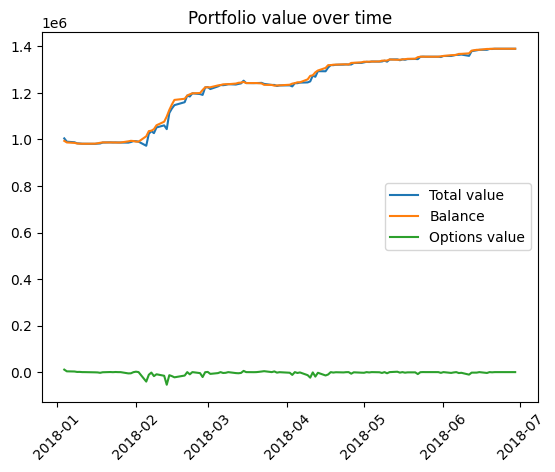

In [ ]:
if run_optimizing == False:
    plot(df)

### Finding best thresholds

In [ ]:
if run_optimizing:
    # Initialize wandb
    !pip install wandb
    import wandb
    wandb.login(key="b47bcf387a0571c5520c58a13be35cda8ada0a99")

    # Define the hyperparameters
    sweep_config = {
    'method': 'grid',
    'name': 'Latest pricing model - 1H18',
    'metric': {
        'goal': 'maximize', 
        'name': 'sharpe_ratio'
        },
    'parameters': {
        'buy_threshold': {
            'values': [1.1, 1.06, 1.04, 1.02]},
        'sell_threshold': {
            'values': [1.1, 1.06, 1.04, 1.02]},
        'starting_balance': {
            'values': [1000000]},
        'price_cap_lower': {
            'values': [5, 1, 0]},
        }
    }
    sweep_id = wandb.sweep(sweep=sweep_config, project='options-trading') 


In [ ]:
if run_optimizing:
    def find_best_thresholds(df = df):
        run = wandb.init(project = "options-trading")
        df = df.copy()
        buy_signal, sell_signal = generate_buy_sell_signals(df, run.config.buy_threshold, run.config.sell_threshold)
        df = trader(df, buy_signal, sell_signal, run.config.starting_balance, price_cap_lower = run.config.price_cap_lower)
        df = calculate_options_value(df)
        run.log({"buy_threshold": run.config.buy_threshold, "sell_threshold": run.config.sell_threshold, "sharpe_ratio": sharpe_ratio2(df), "starting_balance": run.config.starting_balance, "ending_balance": df['Balance'].iloc[-1], "number_of_trades": df['Signal'].abs().sum()})
        # Wandb callback
        print("buy_threshold", run.config.buy_threshold)
        print("sell_threshold", run.config.sell_threshold)
        print("starting_balance", run.config.starting_balance)
        print("Ending balance", df['Balance'].iloc[-1])
        print("Number of trades", df['Signal'].abs().sum())
        print("sharpe_ratio", sharpe_ratio(df))
        plot(df)
        run.finish()

    wandb.agent(sweep_id=sweep_id, function=find_best_thresholds, project='options-trading', count = 1000)